In [1]:
# -*- coding: utf-8 -*-
"""
From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 

Video explanation: 
Got any questions leave a comment on youtube :)

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding
"""

import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)

C:\Users\kheli\AppData\Local\Programs\Python\Python39\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channels = 3
num_classes = 3
learning_rate = 0.001
batch_size = 1
num_epochs = 200

# Load Data
data_dir = '../proof-data/proof-data-rex'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/val'

# Transforms for the training, validation, and testing sets
training_transforms, validation_transforms, testing_transforms = data_transforms()

# Load the datasets with ImageFolder
training_dataset, validation_dataset, testing_dataset = load_datasets(train_dir, training_transforms, valid_dir, validation_transforms, test_dir, testing_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

# Initialize network
model = ResNet50(in_channels,num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    print(f"epoch : {epoch} \t")
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

PATH = "models/rexnet/rexnet50-3ch3-proof.pt"
print("Saving mode ... ")
torch.save(model.state_dict(), PATH)
print(f"Saved at : {PATH}")

epoch : 0 	


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


epoch : 1 	


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


epoch : 2 	


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


epoch : 3 	


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


epoch : 4 	


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


epoch : 5 	


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


epoch : 6 	


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


epoch : 7 	


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


epoch : 8 	


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


epoch : 9 	


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


epoch : 10 	


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


epoch : 11 	


 88%|████████▊ | 7/8 [00:02<00:00,  2.96it/s]

In [4]:
PATH = "models/rexnet/rexnet-3ch2.pt"
print("Saving model ... ")
torch.save(model.state_dict(), PATH)
print(f"Saved at : {PATH}")

Saving model ... 
Saved at : models/rexnet/rexnet-3ch2.pt


In [8]:
PATH = "models/rexnet/rexnet50-3ch3-proof.pt"
mdl = ResNet50(img_channel=3,num_classes=3)
model = torch.load(PATH)
mdl.load_state_dict(model)
mdl.eval()
mdl = mdl.to('cuda')
print('rexnet model loaded!')

rexnet model loaded!


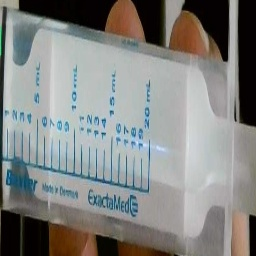

im shape : torch.Size([3, 256, 256])
im shape : torch.Size([3, 256, 256])
tensor([2], device='cuda:0')
['10ml', '1ml', '20ml', '3ml', '5ml', '60ml', '6ml', 'cap']



'20ml'

In [6]:
import cv2
import numpy as np
from torchvision import transforms
import torch
import rexTransform as rex

from PIL import Image
im = Image.open("cutout1.jpg")
im = im.convert("RGB")

display(im)
#im = im[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
#im = np.ascontiguousarray(im, dtype=np.float32)  # uint8 to float32
testing_transforms = transforms.Compose([transforms.Resize((256,256)),
                                             transforms.ToTensor(),
                                             rex.Normalize(by=255)]
                                             )


#im = im[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
im = testing_transforms(im)


print(f"im shape : {im.shape}")
pth = "cutout2_trans.jpg"
print(f"im shape : {im.shape}")

im = np.ascontiguousarray(im, dtype=np.float32)  # uint8 to float32
im = im[None,...]
im = torch.tensor(im)
mdl.eval()
im = im.to('cuda')

scores = mdl(im)
_ , predictions = scores.max(1)

print(predictions)
print(test_loader.dataset.classes)
print()
test_loader.dataset.classes[predictions]

In [7]:
from operator import index

comp = Image.open("../crops/test\\10ml\\WIN_20220618_12_47_28_Pro.jpg")
comp = comp.convert("RGB")
comp = testing_transforms(comp)

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            #print((comp - x[0]).mean())
            ##print((im[0] - x[0]).mean())
            print("model pred")
            print(model(x[None,0]).max(1)[1])
            scores = model(x)
            _, predictions = scores.max(1)

            
            print(f"predictions: {predictions}")

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            indexs = (predictions == y).detach().cpu().numpy()
            print(np.array(loader.dataset.imgs)[indexs])




    model.train()
    return num_correct/num_samples

# Load Data
data_dir = '../crops'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Transforms for the training, validation, and testing sets
training_transforms, validation_transforms, testing_transforms = data_transforms()

# Load the datasets with ImageFolder
training_dataset, validation_dataset, testing_dataset = load_datasets(train_dir, training_transforms, valid_dir, validation_transforms, test_dir, testing_transforms)


test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=27)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(f"Accuracy on test set: {check_accuracy(test_loader, mdl.to(device))*100:.2f}")


model pred
tensor([6], device='cuda:0')
predictions: tensor([6, 6, 6, 1, 1, 5, 2, 3, 3, 5, 5, 3, 7], device='cuda:0')
[['../crops/test\\1ml\\WIN_20220618_12_44_56_Pro.jpg' '1']
 ['../crops/test\\1ml\\WIN_20220618_12_45_07_Pro.jpg' '1']
 ['../crops/test\\20ml\\WIN_20220618_12_48_12_Pro.jpg' '2']
 ['../crops/test\\3ml\\WIN_20220618_12_45_41_Pro.jpg' '3']
 ['../crops/test\\60ml\\WIN_20220618_12_49_12_Pro.jpg' '5']
 ['../crops/test\\60ml\\WIN_20220618_12_49_15_Pro.jpg' '5']
 ['../crops/test\\cap\\WIN_20220618_12_45_03_Pro.jpg' '7']]
Accuracy on test set: 53.85


In [7]:
training_dataset.imgs.pop()

('../crops/train\\cap\\WIN_20220618_12_49_12_Pro.jpg', 7)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from PIL import Image
import json

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
import rexTransform as rex



# Define transforms for the training, validation, and testing sets
def data_transforms():
    training_transforms = transforms.Compose([transforms.Resize((224,224)),
                                              #transforms.RandomRotation(30),
                                              #transforms.RandomResizedCrop(224),
                                              #transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              rex.Normalize(by=255)])

    validation_transforms = transforms.Compose([transforms.Resize((224,224)),
                                                #transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                rex.Normalize(by=255)])

    testing_transforms = transforms.Compose([transforms.Resize((256,256)),
                                             #transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             rex.Normalize(by=255)]
                                             )
    
    return training_transforms, validation_transforms, testing_transforms

# Load the datasets with ImageFolder
def load_datasets(train_dir, training_transforms, valid_dir, validation_transforms, test_dir, testing_transforms):
    training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
    validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
    testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)
    
    return training_dataset, validation_dataset, testing_dataset
    

# Hyperparameters
in_channels = 3
num_classes = 3
learning_rate = 0.001
batch_size = 1
num_epochs = 200

# Load Data
data_dir = '../crops'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
# Transforms for the training, validation, and testing sets
training_transforms, validation_transforms, testing_transforms = data_transforms()

# Load the datasets with ImageFolder
training_dataset, validation_dataset, testing_dataset = load_datasets(train_dir, training_transforms, valid_dir, validation_transforms, test_dir, testing_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)


# Function for processing a PIL image for use in the PyTorch model
def process_image(image_path, hidden_size):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((hidden_size, 256))
    else:
        pil_image.thumbnail((256, hidden_size))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image


# Function to convert a PyTorch tensor and display it
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


# Load class_to_name json file 
def load_json(json_file):
    
    with open(json_file, 'r') as f:
        flower_to_name = json.load(f)
        return flower_to_name
    
    
# Function to display an image along with the top 5 classes
def display_image(image_dir, flower_to_name, classes):

    # Plot flower input image
    plt.figure(figsize = (6,10))
    plot_1 = plt.subplot(2,1,1)

    image = process_image(image_dir)
    
    key = image_dir.split('/')[-2]

    flower_title = flower_to_name[key]

    imshow(image, plot_1, title=flower_title);

    # Convert from the class integer encoding to actual flower names
    flower_names = [flower_to_name[i] for i in classes]

    # Plot the probabilities for the top 5 classes as a bar graph
    plt.subplot(2,1,2)

    sb.barplot(x=probs, y=flower_names, color=sb.color_palette()[0]);

    plt.show()


In [8]:
data_dir = '../flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Transforms for the training, validation, and testing sets
training_transforms, validation_transforms, testing_transforms = data_transforms()

# Load the datasets with ImageFolder
training_dataset, validation_dataset, testing_dataset = load_datasets(train_dir, training_transforms, valid_dir, validation_transforms, test_dir, testing_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)